# IMPORTS AND DATA STORAGE

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [3]:
cols = ['fileName','noun','fake','size','start','end']
indexer = pd.DataFrame(columns=cols)
df = pd.DataFrame(columns=range(768))
listNouns = ['article','beard','blood','company','death','gun','id','interview','passport']
#Load NOUN datasets
for noun in listNouns:
    arrF = np.load('BERTfiles/'+noun+'FAKE.npy')
    arrNF = np.load('BERTfiles/'+noun+'.npy')
    
    count=len(df)
    df = df.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,True,arrF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    count=len(df)
    df = df.append(pd.DataFrame(arrNF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'.npy',noun,False,arrNF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    print("loaded for "+noun)

#-------------------------------------------------------------------------[FAKE]_NOUN_
#Define a dataframe that contains embeddings with FAKE
priv = ['beard','blood','company','death','gun']
indexer.insert(loc=3,column='privative',value=False)
for index, row in indexer.iterrows():
    if row['noun'] in priv:
        indexer.at[index,'privative']= True
        
priv_fakes_idx = indexer[(indexer.fake) & (indexer.privative)]
non_priv_fakes_idx = indexer[(indexer.fake==True) & (indexer.privative==False)]

fake_nouns = pd.DataFrame(columns=range(768))
for index, row in indexer[indexer['fake']].iterrows():
    fake_nouns=fake_nouns.append(df.loc[row['start']:row['end']])

#affine this dataframe : add a 'priv' column
if 'priv' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['priv'])
    
fake_nouns.insert(loc=768,column='priv',value=-1)
for index, row in priv_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'priv']= 1

#add 'noun' column
if 'noun' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['noun'])
    
fake_nouns.insert(loc=768,column='noun',value='')
for index, row in indexer[indexer['fake']].iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'noun']= row['noun']

targets_Fnouns = fake_nouns['priv']
nouns_Fnouns = fake_nouns['noun']
X_Fnouns = fake_nouns.drop(columns=['priv','noun'])

#---------------------------------------------------------------------[NOT FAKE]_NOUN_
not_fake_nouns = pd.DataFrame(columns=range(768))

priv_not_fakes_idx = indexer[(indexer.fake==False) & (indexer.privative)]

for index, row in indexer[indexer['fake']==False].iterrows():
    not_fake_nouns=not_fake_nouns.append(df.loc[row['start']:row['end']])

if 'priv' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['priv'])
    
not_fake_nouns.insert(loc=768,column='priv',value=-1)
for index, row in priv_not_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'priv']= 1


if 'noun' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['noun'])
    
not_fake_nouns.insert(loc=768,column='noun',value='')
for index, row in indexer[indexer['fake']==False].iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'noun']= row['noun']

targets_NFnouns = not_fake_nouns['priv']
nouns_NFnouns = not_fake_nouns['noun']
X_NFnouns = not_fake_nouns.drop(columns=['priv','noun'])

loaded for article
loaded for beard
loaded for blood
loaded for company
loaded for death
loaded for gun
loaded for id
loaded for interview
loaded for passport


In [4]:
cols = ['fileName','noun','size','start','end']
indexer_fakes = pd.DataFrame(columns=cols)
fakes_embd = pd.DataFrame(columns=range(768))

for noun in listNouns:
    arrF = np.load('BERTfiles/FAKE'+noun+'FAKE.npy')
    count=len(fakes_embd)
    fakes_embd = fakes_embd.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,arrF.shape[0],count,len(fakes_embd)-1]],columns=cols)
    indexer_fakes = indexer_fakes.append(d_temp,ignore_index=True)
    
    print("done for "+noun)
    
fakes_embd.index = X_Fnouns.index #re-indexing

if 'priv' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['priv'])
    
fakes_embd.insert(loc=768,column='priv',value=fake_nouns['priv'])

if 'noun' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['noun'])
    
fakes_embd.insert(loc=768,column='noun',value=fake_nouns['noun'])

targets_fakes = fakes_embd['priv']
nouns_fakes = fakes_embd['noun']
X_fakes = fakes_embd.drop(columns=['priv','noun'])

done for article
done for beard
done for blood
done for company
done for death
done for gun
done for id
done for interview
done for passport


In [5]:
# Here we don't need to extract a sample, we already computed only 10% on notfake NOUNS but to have same variable name, we will still define not_fake_samples
not_fake_samples = not_fake_nouns.loc[not_fake_nouns.sample(int(len(not_fake_nouns)/10)).index.sort_values()]
#The preservation of class (nouns) proportions is ensured by the size of the sample (around 8700 items)
targets_nfs = not_fake_samples['priv']
nouns_nfs = not_fake_samples['noun']
X_nfs = not_fake_samples.drop(columns=['priv','noun'])
not_fake_samples

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,noun,priv
83,0.755136,0.232570,-0.199666,0.463767,0.663022,-1.199443,-0.391038,1.085326,0.189961,-0.171142,...,0.036742,-0.650511,0.380231,0.306065,0.295004,-0.089623,-0.543798,0.043758,article,-1
93,1.185707,-0.965881,-0.134034,-0.095874,-0.046036,-0.208575,0.468254,0.951165,-0.070373,0.453378,...,-0.691641,0.600434,0.848339,-0.128943,-1.459426,-0.146330,0.370305,-1.407047,article,-1
101,0.782724,0.506377,-0.448011,-0.556068,0.467412,-0.643761,-0.427728,0.342462,0.436767,0.207104,...,-1.013509,-0.551798,0.523207,-0.201522,-0.612217,0.381392,-0.612997,0.056520,article,-1
126,0.701446,-0.311365,0.127494,0.030786,0.170403,-0.246164,0.046965,0.805459,0.275887,-0.424754,...,0.687348,-0.032467,0.321795,-0.173036,-0.895841,-0.292700,0.086066,-0.196195,article,-1
128,0.972679,0.054844,-0.076094,-0.291104,0.058529,-0.178162,0.731216,-0.187025,0.538008,0.233684,...,-0.376252,-0.083929,0.086797,0.533830,-0.397422,0.029816,-0.145380,-0.362320,article,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90506,0.999951,-0.386783,0.205339,-0.431766,1.617047,-1.417630,-0.474494,-0.106243,0.857382,0.123473,...,0.320106,-0.937458,0.368143,0.042559,-1.274297,-0.237663,0.192799,0.300950,passport,-1
90514,1.300100,-0.388383,0.667170,-0.999018,1.934947,-1.342795,-0.659183,0.274146,0.555000,0.098946,...,0.552925,-0.517290,-0.236130,0.203512,-1.043140,-0.613774,0.579698,0.923594,passport,-1
90516,1.584893,-1.034195,-0.025084,-0.904801,1.695554,-1.740821,-0.452197,0.070314,0.703522,0.007931,...,0.376869,-0.288240,0.120236,0.411534,-0.924830,-0.430465,0.367165,1.269298,passport,-1
90532,1.199506,-0.984206,0.451160,-0.232176,1.362972,-1.166254,-0.254412,0.426088,0.386255,0.333924,...,-0.053407,-0.437864,0.858423,0.170263,-1.177772,-0.303406,0.612004,0.504854,passport,-1


In [5]:
nouns_NFnouns.value_counts()

article      12453
blood        11614
gun          11450
company      11333
death        10728
interview    10616
id            9059
passport      8975
beard         3744
Name: noun, dtype: int64

## Datasets storage reminder : 
* [fake] **NOUN** : fake_nouns ; indexer ; X_Fnouns ; targets_Fnouns ; nouns_Fnouns
* [not fake] **NOUN** : not_fake_nouns ; indexer ; X_NFnouns ; targets_NFnouns ; nouns_NFnouns
* **sampled** [not fake] **NOUN** : not_fake_samples ; - ; X_nfs ; targets_nfs ; nouns_nfs
* **FAKE** : fakes_embd ; indexer_fakes ; X_fakes ; targets_fakes ; nouns_fakes

In [26]:
datasets = {'FAKES': [fakes_embd, X_fakes,targets_fakes, nouns_fakes],
            'fake NOUNS': [fake_nouns, X_Fnouns, targets_Fnouns, nouns_Fnouns],
            'not fake NOUNS': [not_fake_samples, X_nfs, targets_nfs, nouns_nfs]
           }

# VISUALISATIONS

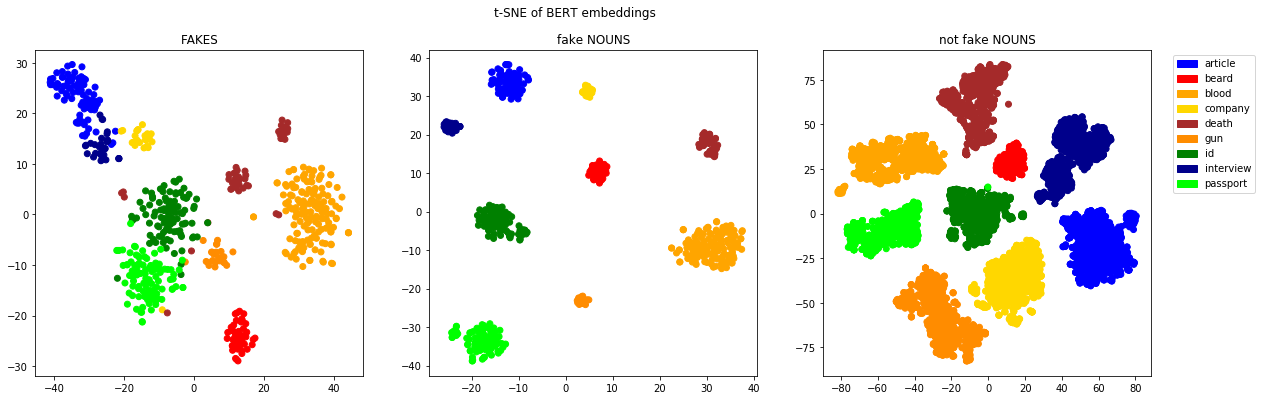

In [28]:
tsne = TSNE(n_components=2, init='pca', random_state=0)

colors={'article':'blue','beard':'red','blood':'orange','company':'gold','death':'brown','gun':'darkorange','id':'green','interview':'darkblue','passport':'lime'}

fig, ax = plt.subplots(1,3,figsize=(20,6)) #projection='3d'
for i, dataset in enumerate(datasets.keys()):
    trans_data = tsne.fit_transform(datasets[dataset][1]).T

    ax[i].scatter(trans_data[0], trans_data[1], color=datasets[dataset][-1].map(colors))
    ax[i].set_title(dataset)

handles = [mpatches.Patch(color=colors[n],label=n) for n in ('article','beard','blood','company','death','gun','id','interview','passport')]
plt.legend(handles = handles,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("t-SNE of BERT embeddings")
plt.axis('tight')
plt.savefig("TSNE_BERT.png",dpi=300,bbox_inches = 'tight',pad_inches = 1)
plt.show()

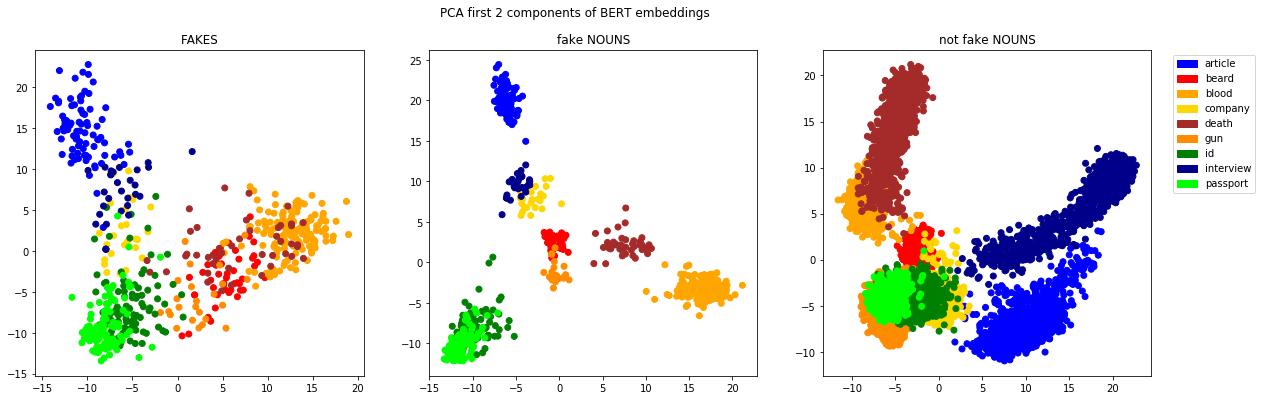

In [30]:
scaler = Scaler()
pca = PCA(n_components=2)

colors={'article':'blue','beard':'red','blood':'orange','company':'gold','death':'brown','gun':'darkorange','id':'green','interview':'darkblue','passport':'lime'}

fig, ax = plt.subplots(1,3,figsize=(20,6)) #projection='3d'
for i, dataset in enumerate(datasets.keys()):
    
    trans_data = pca.fit_transform( scaler.fit_transform(datasets[dataset][1]) ).T

    ax[i].scatter(trans_data[0], trans_data[1], color=datasets[dataset][-1].map(colors))
    ax[i].set_title(dataset)

handles = [mpatches.Patch(color=colors[n],label=n) for n in ('article','beard','blood','company','death','gun','id','interview','passport')]
plt.legend(handles = handles,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("PCA first 2 components of BERT embeddings")
plt.axis('tight')
plt.savefig("PCA_BERT.png",dpi=300,bbox_inches = 'tight',pad_inches = 1)
plt.show()

In [32]:
def Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess=None,k=2,show_kbest=False):
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    else:
        model = classifier
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    Tacc = np.sum(Ttrain == y_train)/len(Xtrain)
    y_banned = model.predict(Xbanned)
    Bacc = np.sum(Tbanned == y_banned)/len(Xbanned)
    return (Tacc,Bacc)

def BNC_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,full_output=False,debug=False,show_kbest=False):
    if debug:
        print("\rTest {} : BNC  starting%                     ".format(debug), end="")
        sys.stdout.flush()
    Taccs = np.zeros(len(listNouns))
    Baccs = np.zeros(len(listNouns))
    
    for i,bannedW in enumerate(listNouns):
        if debug:
            print("\rTest {} : BNC for {} ; {}%             ".format(debug, bannedW, 100 * i // len(listNouns)), end="")
            sys.stdout.flush()
        Xtrain = X[nouns!=bannedW]
        Ttrain = targets[nouns!=bannedW]
        if preprocess=='kbest':
            select = SelectKBest(MIC,k).fit(Xtrain,Ttrain)
            scaler = Scaler()
            Xtrain = scaler.fit_transform(select.transform(Xtrain))
            if show_kbest:
                print("({})".format(np.where(select.get_support())[0]))
        Xbanned = X[nouns==bannedW]
        if preprocess == 'kbest':
            Xbanned = scaler.transform(select.transform(Xbanned))
        Tbanned = targets[nouns==bannedW]
        Tacc,Bacc = Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess,k,show_kbest)
        Taccs[i],Baccs[i] = Tacc, Bacc
    AvgTrain = np.mean(Taccs)
    AvgBanned = np.mean(Baccs)
    if full_output:
        return (Taccs,Baccs)
    else:
        return (AvgTrain,AvgBanned)

In [48]:
def find_best_BNC_model(dataset):
    warnings.filterwarnings('ignore') #ignore Warnings

    preprocesses = [None,'pca','tsne','kbest','kbest']
    models = ['Linear SVM', 'RBF SVM', 'Nearest Centroid']
    embds, X, targets, nouns = dataset
    kbest10 = False
    for i,preproc in enumerate(preprocesses):
        if preproc is None:
            print('-------------------- RAW DATA --------------------' )
        elif preproc == 'kbest':
            if kbest10:
                print('-------------------- {} (10) --------------------'.format(preproc) )
            else:
                print('-------------------- {} (2) --------------------'.format(preproc) )
        else:
            print('-------------------- {} --------------------'.format(preproc) )
        for j,model in enumerate(models):
            if model=='Linear SVM':
                clf = LinearSVC
                params = {'max_iter':100000}
            elif model=='RBF SVM':
                clf = SVC
                params = {'kernel':'rbf'}
            elif model == 'Nearest Centroid':
                clf = NearestCentroid
                params = dict()
            if preproc == 'kbest' and kbest10: #10-best 
                SBNC_train, SBNC_test = BNC_accuracy(clf(**params),X,targets,nouns,preprocess=preproc,k=10,debug=int(str(i+1)+str(j+1)))
            else: #all the rest
                SBNC_train, SBNC_test = BNC_accuracy(clf(**params),X,targets,nouns,preprocess=preproc,k=2,debug=int(str(i+1)+str(j+1)))
            
            print('\r{} ::   Train BNC : {}  Score BNC : {}'.format(model, np.round(SBNC_train,4), np.round(SBNC_test,4) ) )
            
        if preproc == 'kbest' and not kbest10:
            kbest10 = True
    warnings.filterwarnings('default')

# FAKE embeddings

In [49]:
find_best_BNC_model(datasets['FAKES'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8408
RBF SVM ::   Train BNC : 0.9993  Score BNC : 0.8614
Nearest Centroid ::   Train BNC : 0.9483  Score BNC : 0.8268
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8445
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.849
Nearest Centroid ::   Train BNC : 0.9518  Score BNC : 0.8265
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8408
RBF SVM ::   Train BNC : 0.9993  Score BNC : 0.8614
Nearest Centroid ::   Train BNC : 0.9483  Score BNC : 0.8268
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9029  Score BNC : 0.4963
RBF SVM ::   Train BNC : 0.9045  Score BNC : 0.5002
Nearest Centroid ::   Train BNC : 0.8994  Score BNC : 0.5596
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 0.9665  Score BNC : 0.7371
RBF SVM ::   Train BNC : 0.9738  Scor

In [50]:
find_best_BNC_model(datasets['fake NOUNS'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8157
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.8708
Nearest Centroid ::   Train BNC : 0.9845  Score BNC : 0.6236
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8664
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.8452
Nearest Centroid ::   Train BNC : 0.9914  Score BNC : 0.6748
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8157
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.8708
Nearest Centroid ::   Train BNC : 0.9845  Score BNC : 0.6236
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9873  Score BNC : 0.6794
RBF SVM ::   Train BNC : 0.9887  Score BNC : 0.6913
Nearest Centroid ::   Train BNC : 0.9861  Score BNC : 0.7549
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.9583
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.9

In [51]:
find_best_BNC_model(datasets['not fake NOUNS'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.813
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.818
Nearest Centroid ::   Train BNC : 0.9981  Score BNC : 0.7019
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.8372
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.8398
Nearest Centroid ::   Train BNC : 0.9987  Score BNC : 0.7502
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.813
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.818
Nearest Centroid ::   Train BNC : 0.9981  Score BNC : 0.7019
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9608  Score BNC : 0.649
RBF SVM ::   Train BNC : 0.962  Score BNC : 0.6528
Nearest Centroid ::   Train BNC : 0.9565  Score BNC : 0.7056
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 0.9995  Score BNC : 0.9304
RBF SVM ::   Train BNC : 0.9997  Score BNC : 0.9